<a href="https://colab.research.google.com/github/ddekun/Megafon_course_project/blob/Megafon_course_project/Megafon_course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовая работа. Мегафон.

Необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность
подключения услуги.

- id - идентификатор абонента
- vas_id - подключаемая услуга
- buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime
- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion, make_pipeline

import matplotlib.pyplot as plt
%matplotlib inline

import dask.dataframe as dd
from datetime import datetime, date, time
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path_train = 'data_train.csv'
path_test = 'data_test.csv'
path_features = 'features.csv'
path_pred = 'answers_test.csv'
MODEL_FILE_PATH = 'model.pkl'

### Загрузка данных

In [ ]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [ ]:
df_train['buy_time'] = df_train['buy_time'].apply(lambda x: date.fromtimestamp(x))
df_test['buy_time'] = df_test['buy_time'].apply(lambda x: date.fromtimestamp(x))

In [ ]:
df_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,2018-09-17,0.0
1,1,1454121,4.0,2018-07-16,0.0
2,2,2458816,1.0,2018-08-13,0.0
3,3,3535012,5.0,2018-09-03,0.0
4,4,1693214,1.0,2018-09-03,0.0


In [ ]:
df_features = dd.read_csv('features.csv', sep='\t')
df_features['buy_time'] = df_features['buy_time'].apply(lambda x: date.fromtimestamp(x), meta=('buy_time', 'object'))
df_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,2018-07-16,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,2018-10-15,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,2018-12-24,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,2018-08-13,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,2018-08-06,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [ ]:
df_merge = dd.merge(df_train, df_features, on=['id', 'buy_time'], how='inner')
df_merge_test = dd.merge(df_test, df_features, on=['id', 'buy_time'], how='inner')

In [ ]:
# Перевод из dask в pandas

df_merge = df_merge.compute()
df_merge_test = df_merge_test.compute()

In [ ]:
df_merge.describe()

,Unnamed: 0_x,id,vas_id,target,Unnamed: 0_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
count,38919.000000,3.891900e+04,38919.000000,38919.000000,3.891900e+04,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,...,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000,38919.000000
mean,419486.076004,2.154005e+06,2.801562,0.067885,2.259702e+06,-0.653179,-1.564541,-1.144136,-2.513602,-1.225731,...,-18.027794,-3.666550,0.361963,-0.543627,-17.829663,-2.040782,-0.024627,-1.846917,0.003353,0.257843
std,240312.262815,1.262414e+06,1.978314,0.251551,1.309179e+06,194.172807,399.922474,204.543990,451.883977,229.993395,...,3167.200100,2225.590690,1081.353728,288.871988,1086.209541,145.695314,6.176294,97.109281,5.616058,0.557951
min,37.000000,2.000000e+00,1.000000,0.000000,1.580000e+02,-411.719971,-468.019112,-421.420786,-512.156798,-426.838246,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,212346.500000,1.064699e+06,1.000000,0.000000,1.117424e+06,-96.799971,-212.474112,-110.740786,-244.656798,-116.158246,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,419399.000000,2.132826e+06,2.000000,0.000000,2.261589e+06,-86.199971,-61.669112,-87.160786,-79.426798,-90.378246,...,-959.373846,-613.770792,-25.996269,-37.630448,-239.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,625607.000000,3.249143e+06,5.000000,0.000000,3.390411e+06,9.505029,115.855888,24.694214,122.128202,24.906754,...,-497.373846,-411.770792,-24.996269,-32.630448,-80.747724,-10.832889,-0.694428,-9.175933,-0.456140,1.000000
max,831628.000000,4.362640e+06,9.000000,1.000000,4.512309e+06,9235.090029,20564.850888,9221.149214,20641.873202,10900.661754,...,141554.626154,72800.229208,150072.003731,21326.369552,40816.252276,9120.167111,582.305572,9131.824067,508.543860,68.000000


### Получаем тренировочный набор данных

In [ ]:
df_merge['target'] = df_merge['target'].astype(int)

In [ ]:
X_train = df_merge.drop('target', axis=1)
X_test = df_merge_test

In [ ]:
Y_train = df_merge['target']

In [ ]:
y_list = []
y_list.append(df_train[df_train['target']==0].shape[0])
y_list.append(df_train[df_train['target']==1].shape[0])
print(f'target = 0 - {y_list[0]}, target = 1 - {y_list[1]}')

target = 0 - 771467, target = 1 - 60186


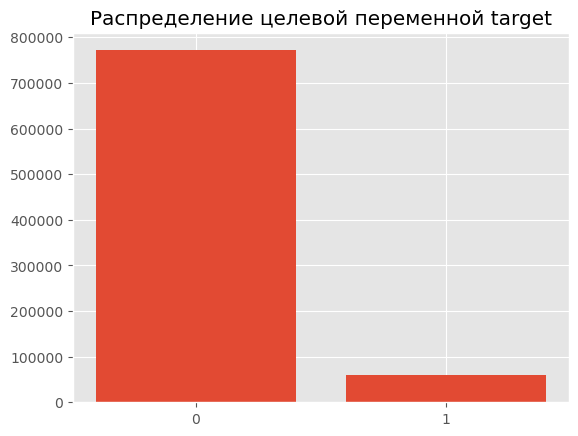

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.bar(np.arange(2), y_list)
ax.set(xticks=np.arange(2))
ax.set_title('Распределение целевой переменной target')
plt.show()

### Балансировка классов

In [ ]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    return df.sample(frac=1) 

In [ ]:
df_for_balancing = pd.concat([X_train, Y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'target', method='under') 
df_balanced['target'].value_counts()

1    2642
0    2642
Name: target, dtype: int64

In [ ]:
X_train = df_balanced.drop('target', axis=1)
Y_train = df_balanced['target']

### Определение типа признаков

In [ ]:
# Составление списка колонок датафрейма
columns = [col for col in X_train.columns]

In [ ]:
# Выбор признаков для обработки в pipline 
for x in ['Unnamed: 0_x', 'Unnamed: 0_y']:
    columns.remove(x)

In [ ]:
# Преобразуем признак buy_time в год

X_train['buy_time'] = X_train['buy_time'].apply(lambda x: x.year)

In [ ]:
X_train = X_train[columns]
X_test = X_test[columns]

In [ ]:
def find_feature(X_train):
    # Просмотр и оценка признаков
    X_nunique = X_train.apply(lambda x: x.nunique(dropna=False))
    f_all = set(X_nunique.index.tolist())

    # константные признаки
    f_const = set(X_nunique[X_nunique == 1].index.tolist())

    # вещественные признаки
    f_numeric = (X_train.fillna(0).astype(int).sum() - X_train.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())

    f_other = f_all - (f_numeric | f_const)

    # бинарные
    f_binary = set(X_train.loc[:, f_other].columns[(
                          (X_train.loc[:, f_other].max() == 1) & \
                          (X_train.loc[:, f_other].min() == 0) & \
                          (X_train.loc[:, f_other].isnull().sum() == 0))])

    f_other = f_other - f_binary

    # категориальные
    f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())

    f_numeric_extra = f_categorical
    f_other = f_other - f_categorical
    f_numeric = f_numeric | f_other
    f_other = f_other - f_numeric

    print(f'Признаки {len(f_all)}')
    print(f'Константные признаки {len(f_const)}')
    print(f'Вещественные признаки {len(f_numeric)}')
    print(f'Бинарные признаки {len(f_binary)}')
    print(f'Категориальные признаки {len(f_categorical)}')
    print(f'Остальные признаки {len(f_other)}')
    f_ok = list(f_binary | f_categorical | f_numeric)
    f_const, f_binary, f_categorical, f_numeric = list(f_const), list(f_binary), list(f_categorical), list(f_numeric)
    
    return f_ok, f_const, f_binary, f_categorical, f_numeric

### Создание пайплайна

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f'DataFrame не содердит следующие колонки: {cols_error}')

In [ ]:
f_ok, f_const, f_binary, f_categorical, f_numeric = find_feature(X_train)

Признаки 256
Константные признаки 17
Вещественные признаки 248
Бинарные признаки 1
Категориальные признаки 1
Остальные признаки 0


In [ ]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [ ]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['15', '69', '198', '227', '232', '127', '187', '211',
                          '46', '146', '242', '200', '87', '122', '205', '161',
                          '7', '78', '114', '234', '19', '98', '61', '68', '67',
                          '247', '223', '250', 'vas_id', '120', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['15',
                                                                           '69',
                                                                           '198',
                                                                           '227',
                                                                           '232',
                                                                           '127',
                                    

In [ ]:
f_prep_pipeline.fit(X_train)
n_features = f_prep_pipeline.transform(X_train).shape[1]
print(f'Количество обработанных признаков с помощью fit, transfofm - {n_features}')

Количество обработанных признаков с помощью fit, transfofm - 257


In [ ]:
f_prep_pipeline

Pipeline(steps=[('columnselector',
                 ColumnSelector(columns=['15', '69', '198', '227', '232', '127',
                                         '187', '211', '46', '146', '242',
                                         '200', '87', '122', '205', '161', '7',
                                         '78', '114', '234', '19', '98', '61',
                                         '68', '67', '247', '223', '250',
                                         'vas_id', '120', ...])),
                ('featureunion',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelecto...
                                                                  SimpleImputer()),
                                                                 ('standardscaler',
                                                                  StandardScaler())])),
                                                ('categorical_features',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(columns=['vas_id'])),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('boolean_features',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(columns=['252']))]))]))])

### Градиентный бустинг

In [ ]:
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    GradientBoostingClassifier()
)

In [ ]:
param_grid = {
    "gradientboostingclassifier__max_depth": [3, 5],
    "gradientboostingclassifier__n_estimators": [50, 100]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [ ]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='f1'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [ ]:
%%time
gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, Y_train, param_grid, kfold_cv)

Best f1 score: 0.87

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 50}

Grid scores on development set:

0.870 (+/-0.012) for {'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 50}
0.872 (+/-0.009) for {'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__n_estimators': 100}
0.875 (+/-0.005) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 50}
0.873 (+/-0.004) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100}

CPU times: total: 17.1 s
Wall time: 42.7 s


### Сравнение моделей

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
gb_model = gb_fs_gsc.best_estimator_
gb_model.fit(X_train, Y_train)
y_test_gb = gb_model.predict_proba(X_train)[:,1]

In [ ]:
print('Градиентный бустинг')
print(classification_report(Y_train, y_test_gb > 0.5))

Градиентный бустинг
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2642
           1       0.90      0.89      0.90      2642

    accuracy                           0.90      5284
   macro avg       0.90      0.90      0.90      5284
weighted avg       0.90      0.90      0.90      5284



Confusion matrix, without normalization
[[2388  254]
 [ 294 2348]]


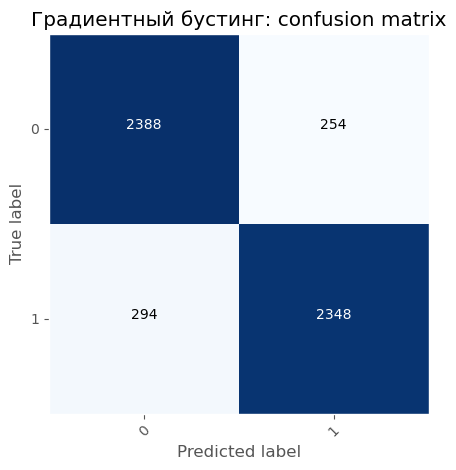

In [ ]:
cm = confusion_matrix(Y_train, y_test_gb > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Градиентный бустинг");

In [ ]:
final_model = gb_model
y_test_preds = final_model.predict_proba(X_test)[:,1]

In [ ]:
y_test_preds[y_test_preds >= 0.5] = 1
y_test_preds[y_test_preds < 0.5] = 0

### Сохранение модели

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as f:
    pickle.dump(final_model, f)

### Сохранение прогнозов

In [ ]:
df_y_pred = pd.DataFrame({'id' : X_test['id'], 'vas_id': X_test['vas_id'], 'buy_time' : X_test['buy_time'] , 'target' : y_test_preds})
df_y_pred.to_csv(path_pred, index=False, encoding='utf-8')
df_y_pred.head()

,id,vas_id,buy_time,target
0,3504271,5.0,2019-01-21,0.0
1,2543272,2.0,2019-01-14,0.0
2,4066976,2.0,2019-01-14,0.0
0,3456715,2.0,2019-01-14,0.0
1,3987315,5.0,2019-01-14,0.0
